# This notebook will make a volcano plot entirely in python, now that the adjustText package has found.
## This library is written for python 3. If you have anaconda installed, then only additional package you'll need is adjustText, which you can install with pip
### this notebook will go through the entire process from the NMR bin shift data and labelled metabolites, to the end result of a volcano plot. I've also included a short cell showing how to generate box plots for metabolites of interest that you've generated from the volcano plot

In [1]:
#load needed libraries, the following come automatically with anaconda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
%matplotlib inline
#this library you'll have to install with pip in command line
from adjustText import adjust_text

In [2]:
#load nmr bin shift data and metabolites labels csv file then pre-process 
data = np.loadtxt('./VolcanoPlots/EMH_bin_shift_data.txt', delimiter= ' ')
labels = pd.read_csv('./VolcanoPlots/Ecoli_MH_FvsS.csv')
cls = data[1:,0]
ppm =data[0, 1:]
df = data[1:,1:]
df.shape, cls.shape, ppm.shape

((20, 1749), (20,), (1749,))

In [3]:
#find indices of ppm values
labels['idx'] = [np.argmin(np.abs(ppm-i)) for i in labels['ppm']]
labels.head()

,metabolite,ppm,idx
0,Leucine,0.967,1658
1,Isoleucine,1.024,1647
2,Valine,0.997,1652
3,Threonine,1.353,1583
4,Acetate,1.939,1469


In [4]:
#create new dataframe with integrals that are associated to identified metabolites
df2 = df[:, list(labels['idx'])]
df2 = pd.DataFrame(df2, columns = labels['metabolite'])
df2['cls'] = cls
df2.head()

metabolite,Leucine,Isoleucine,Valine,Threonine,Acetate,Methionine,Propionate,Glutamate,Succinate,"5,6-dihydrouracile",...,?,Serine,Glucose,Uracil,Uridine,Tyrosine,Phenylalanine,Hypoxanthine,Formate,cls
0,1.103045,0.239547,0.354272,0.071846,1.948215,0.409550,0.134651,0.309750,1.580362,0.064816,...,1.153034,0.041728,0.001175,0.081093,0.000724,0.078666,0.109909,0.002798,0.000132,1.0
1,1.409578,0.318107,0.439371,0.097783,2.270976,0.497375,0.164229,0.401138,2.052057,0.075339,...,1.503796,0.057747,0.003368,0.149192,0.000183,0.106194,0.142037,0.004069,0.000166,1.0
2,1.607807,0.361371,0.503525,0.107015,2.724482,0.573550,0.188889,0.452011,2.263600,0.089615,...,1.683030,0.066523,0.002509,0.126703,0.000280,0.114196,0.163359,0.005071,0.000230,1.0
3,1.535561,0.347631,0.504799,0.103669,2.441122,0.545844,0.190863,0.439846,1.999999,0.086456,...,1.532708,0.064146,0.005161,0.099306,0.000528,0.107324,0.151603,0.003879,0.000189,1.0
4,1.619419,0.343338,0.516791,0.112011,2.869103,0.603847,0.198183,0.455350,2.322054,0.092811,...,1.690905,0.058477,0.001738,0.116270,0.001015,0.115765,0.163214,0.004324,0.000472,1.0


In [5]:
#calclulate p-values comparing mean integral peaks comparing class 0 and class 1
#if your classes are otherwise labelled the modify the code below
#this also adjusts the p-values for multiple tests using the benjamini-hochberg false discovery rate correction
#other methods can be found here:
#http://www.statsmodels.org/devel/generated/statsmodels.sandbox.stats.multicomp.multipletests.html#statsmodels.sandbox.stats.multicomp.multipletests
ps =[stats.ttest_ind(a=df2[df2['cls']==0][i].dropna(), 
                     b=df2[df2['cls']==1][i].dropna())[1] for i in labels['metabolite']]
padj = multipletests(ps, alpha =  0.05, method ='fdr_bh')[1]
print(len(ps), len(padj), labels.shape)
df3= pd.DataFrame({'metabolite':labels['metabolite'],'p':ps, 'padj':padj})

24 24 (24, 3)


In [6]:
#calculate the fold change between class 0 and class 1
#fold change is caculated as class-1/class-0
a=np.mean(df2[df2['cls']==0])
b= np.mean(df2[df2['cls']==1])
fc = b/a
fc =fc.drop('cls')
df3['fc']=list(fc)
df3['log2fc']= np.log2(df3['fc'])
df3['log10padj'] = -np.log(df3['padj'])
df3.head()

,metabolite,p,padj,fc,log2fc,log10padj
0,Leucine,3.773878e-02,3.937960e-02,1.097892,0.134736,3.234507
1,Isoleucine,3.895405e-04,4.451892e-04,1.201669,0.265040,7.717011
2,Valine,6.272959e-05,8.363945e-05,1.266704,0.341080,9.388995
3,Threonine,2.467497e-18,9.869987e-18,0.329519,-1.601566,39.157033
4,Acetate,3.662893e-15,9.767714e-15,6.905590,2.787765,32.259694


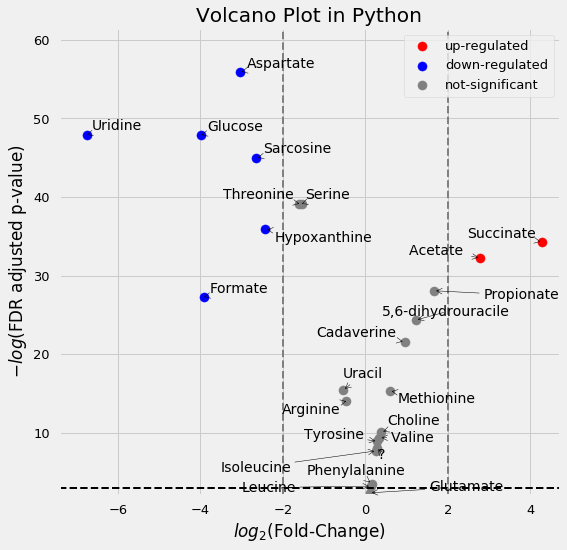

In [16]:
#this cell will make the volcano plot. to save the plot get rid of the commented-out line at the bottom of the cell.
#you can modify all the features of the plot below
sns.set_context('talk')
plt.style.use('fivethirtyeight')
#subset signficant and non-signficant data for plotting
data = df3
dat1 = data[(data['log2fc']> 2) & (data['padj']<0.05)]
dat2 = data[(data['log2fc']<-2) & (data['padj']<0.05)]
dat3 = data[(data['log2fc'] <2) & (data['log2fc']>-2)]

#generate plot
fig,ax = plt.subplots(figsize =(8,8))
ax.scatter(dat1['log2fc'], dat1['log10padj'], color = 'red',  label = 'up-regulated')
ax.scatter(dat2['log2fc'], dat2['log10padj'], color = 'blue', label = 'down-regulated')
ax.scatter(dat3['log2fc'], dat3['log10padj'], color = 'grey', label = 'not-significant')

ax.set_xlim((data['log2fc'].min())*1.1, data['log2fc'].max()*1.1)
ax.set_ylim(data['log10padj'].min()*0.9, data['log10padj'].max()*1.1)
#set label texts
ax.set_xlabel(r'$log_2$(Fold-Change)')
ax.set_ylabel(r'$-log$(FDR adjusted p-value)')
ax.set_title('Volcano Plot in Python')
tok= ax.get_xlim()
kan = ax.get_ylim()
#add boundary lines
ax.hlines(y = -np.log(0.05), xmin = tok[0], xmax = tok[1], linestyles ='--', linewidth = 2)
ax.vlines(x =2, ymin =kan[0], ymax = kan[1], linestyles = '--', color = 'grey' , linewidth =2)
ax.vlines(x =-2, ymin =kan[0], ymax = kan[1], linestyles = '--', color = 'grey', linewidth  =2 )
#add labels to plot and then adjust them so they don't overlap
texts = []
for i in range(len(data)):
    texts.append(ax.text(x = np.log2(data['fc'][i]),
             y =-np.log(data['padj'][i]),
             s = data['metabolite'][i]))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
ax.legend()
#plt.savefig('volcano_plot.png', dpi = 300)

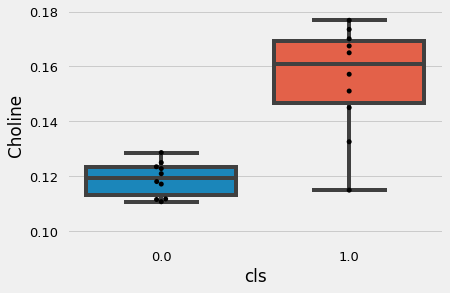

In [17]:
#create boxplot of interesting metabolites
met ='Choline'
sns.swarmplot(x= 'cls', y = met, data = df2, color = 'black')
sns.boxplot(x = 'cls', y = met, data =df2)